In [30]:
# Dependencies:
# 1. Run generate_survey.ipynb to save arrays to local path

In [31]:
# Load libraries
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy import stats, spatial
import string
import functools
import sys
sys.path.append('..')
import helpers
from matplotlib.cm import get_cmap
cmap = np.array(get_cmap('tab10').colors)

## Load survey responses
Convert all times into seconds 

In [32]:
# Load data
survey = pd.read_excel('Vaximap Survey Responses.xlsx', header=1, nrows=19)
survey = survey.dropna()

# Convert all time durations to seconds 
def to_seconds(dt):
    delta = datetime.timedelta(minutes=dt.minute, seconds=dt.second)
    return delta.total_seconds()

times = survey.loc[:,['Route 1 (5)', 'Route 2 (8)', 'Route 3 (12)', 'Time (13)', 'Time (20)', 'Time (26)']]
survey.loc[:,['Route 1 (5)', 'Route 2 (8)', 'Route 3 (12)', 'Time (13)', 'Time (20)', 'Time (26)']] = times.applymap(to_seconds).astype(float)

# Metadata
print('Dataset shape', survey.shape)

# Inspect
survey.tail(5)

Dataset shape (18, 20)


,Note,Age,Sex,Occupation,Route 1 (5),Route 2 (8),Route 3 (12),List,Route 4.1,Route 4.2,Time (13),Route 5.1,Route 5.2,Route 5.3,Time (20),Route 6.1,Route 6.2,Route 6.3,Route 6.4,Time (26)
13,AB6,28,M,Chartered Accountant,195.0,235.0,429.0,Google Maps,"A,G,J,K,E,F,B,A","I,M,H,C,L,D,I",17.0,"I,F,O,J,T,S,R,I","G,K,A,E,N,Q,G","B,L,H,D,C,M,P,B",34.0,"E,L,F,J,H,K,I,E","G,B,A,D,C,G","M,Q,O,P,V,W,R,M","N,T,X,U,Y,Z,S,N",65.0
14,AJB1,76,F,Retired Teacher,2290.0,2420.0,390.0,Postcode A-Z,"H,M,I,D,L,C,H","E,F,B,A,G,J,K,E",88.0,"J,O,F,I,R,S,T,J","A,E,N,Q,G,K,A","H,L,B,P,M,C,D,H",272.0,"H,K,I,E,L,F,J,H","D,C,G,B,A,D","V,T,X,U,Y,Z,S,V","N,P,O,Q,M,R,W,N",575.0
15,AJB2,78,M,Retired,2100.0,2530.0,375.0,Postcode A-Z,"H,M,I,D,L,C,H","E,F,B,A,G,J,K,E",125.0,"J,O,F,I,R,S,T,J","A,E,N,Q,G,K,A","L,B,P,M,C,D,H,L",260.0,"E,L,F,J,H,K,I,E","D,C,G,B,A,D","V,T,X,U,Y,Z,S,V","N,P,O,Q,M,R,W,N",605.0
16,TK3,30,M,IT analyst,191.0,320.0,416.0,Google Maps,"H,M,I,D,L,C,H","G,J,K,E,F,B,A,G",124.0,"O,F,I,R,S,T,J,O","G,K,A,E,N,Q,G","B,P,M,C,D,H,L,B",93.0,"E,L,F,J,H,K,I,E","G,B,A,D,C,G","V,T,X,U,Y,Z,S,V","M,R,W,N,P,O,Q,M",197.0
17,TK4,55,M,Company director,168.0,353.0,520.0,Google Maps,"I,D,L,C,M,H,I","G,J,K,E,F,B,A,G",80.0,"I,S,T,J,F,O,I","R,G,K,A,E,N,Q,R","B,P,C,D,M,H,L,B",70.0,"E,L,F,J,H,K,I,E","G,B,A,D,Y,U,C,G","V,T,X,Z,S,V","R,W,N,P,O,Q,M,R",145.0


In [33]:
# Check the routes of each survey respondent are complete (they contain all the letters we expect)
letter2index = dict(zip(string.ascii_uppercase, np.arange(26)))
index2letter = list(string.ascii_uppercase)

def get_route_length_from_dist_mat(route, dm):
    route = route.split(',')
    if (route[0] != route[-1]) or len(route) > 8: 
        raise RuntimeError("Route error (start/end or length > 7?)", route)
    inds = [ letter2index[i] for i in route ]
    total = sum([ dm[inds[x], inds[x+1]] for x in range(len(inds) - 1) ])
    total += dm[inds[-1], inds[0]]
    return total 

def check_solutions_complete(df, target):
    for row in range(df.shape[0]):
        flat = [] 
        for r in df.iloc[row,:]: 
            flat += r.split(',')
        flat = set(flat)
        for idx in range(target):
            if not index2letter[idx] in flat: 
                raise RuntimeError(f"{df.columns[0][:-2]} for index {df.iloc[row,:].name} incomplete, {index2letter[idx]} missing")


In [34]:
# Check the solutions contain all of the points in the survey arrays

# 13 points (Question 4)
check_solutions_complete(survey.filter(regex=("Route 4")), 13)
points_13 = np.loadtxt('array_13.txt')
dm13 = spatial.distance_matrix(points_13, points_13)
get_route_length = functools.partial(get_route_length_from_dist_mat, dm=dm13)
survey['Total distance 4'] = survey['Route 4.1'].apply(get_route_length) + survey['Route 4.2'].apply(get_route_length)

# 20 points (Question 5)
check_solutions_complete(survey.filter(regex=("Route 5")), 20)
points_20 = np.loadtxt('array_20.txt')
dm20 = spatial.distance_matrix(points_20, points_20)
get_route_length = functools.partial(get_route_length_from_dist_mat, dm=dm20)
survey['Total distance 5'] = (survey['Route 5.1'].apply(get_route_length) + survey['Route 5.2'].apply(get_route_length) 
                              + survey['Route 5.3'].apply(get_route_length))

# 26 points (Question 6)
check_solutions_complete(survey.filter(regex=("Route 6")), 26)
points_26 = np.loadtxt('array_26.txt')
dm26 = spatial.distance_matrix(points_26, points_26)
get_route_length = functools.partial(get_route_length_from_dist_mat, dm=dm26)
survey['Total distance 6'] = (survey['Route 6.1'].apply(get_route_length) + survey['Route 6.2'].apply(get_route_length) 
                              + survey['Route 6.3'].apply(get_route_length) + survey['Route 6.4'].apply(get_route_length))


In [35]:
# Cohort chracteristics 
print('Age: mean', round(survey.Age.mean(),1), ', std', round(survey.Age.std(),1), 
      ', min',round(survey.Age.min(),1), ', max', round(survey.Age.max(),1))
print('Participants: ', survey.shape[0], 'total,', (survey.Sex == 'F').sum(), 'female')

Age: mean 45.6 , std 19.6 , min 26 , max 78
Participants:  18 total, 6 female


## Lookup time regression 
How long does it take people to generate a spatial representation for a TSP?

LinregressResult(slope=36.96355863192182, intercept=14.21213355048863, rvalue=0.8029280533920997, pvalue=1.4599923254925254e-15, stderr=3.4850009479067627)

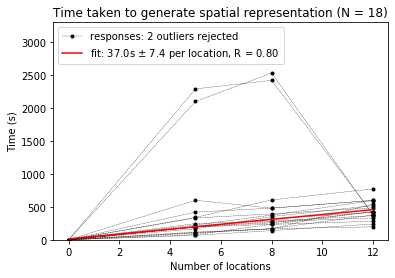

In [36]:
# Get time to complete Questions 1-3
# Detect outliers, set manual threshold as 2000s here 
lookup_time = survey.loc[:,['Route 1 (5)', 'Route 2 (8)', 'Route 3 (12)']].values.astype(float)
lookup_time = np.hstack((np.zeros((lookup_time.shape[0], 1)), lookup_time))
route_size = np.tile([0,5,8,12], (lookup_time.shape[0], 1))

# Do regression, exlcuding outliers 
fltr = (lookup_time < 2000).all(1)
lut_reg = stats.linregress(route_size[fltr,:].flatten(), lookup_time[fltr,:].flatten())

# Calculate 95% interval on slope 
tinv = lambda p, df: abs(stats.t.ppf(p/2, df))
ci = tinv(0.05, len(route_size)-2) * lut_reg.stderr

# Plot data and linear fit
for row in range(lookup_time.shape[0]):
    label = f'responses: {(~fltr).sum()} outliers rejected' if row == 0 else None
    plt.plot(route_size[row], lookup_time[row], 'k--', linewidth=0.33, marker='.', label=label)
route_size_fit = np.linspace(0,12)
lookup_time_fit = lut_reg.intercept + (route_size_fit * lut_reg.slope)
plt.plot(route_size_fit, lookup_time_fit, 'r-', label=r'fit: %.1fs $\pm$ %.1f per location, R = %.2f' % (lut_reg.slope, ci, lut_reg.rvalue))
plt.legend(loc='upper left')
plt.ylabel('Time (s)')
plt.xlabel('Number of locations')
plt.title(f'Time taken to generate spatial representation (N = {fltr.size})')
plt.ylim(0,3300)
plt.savefig('lut_fit.png', dpi=250, bbox_inches='tight')

# Print coefficients
lut_reg 


## Routing time regression 
How long does it take people to generate routes from a spatial representation?

LinregressResult(slope=4.6564793195463645, intercept=-1.7924449633088813, rvalue=0.7422445129948336, pvalue=2.2382215032685462e-12, stderr=0.5339165096968358)

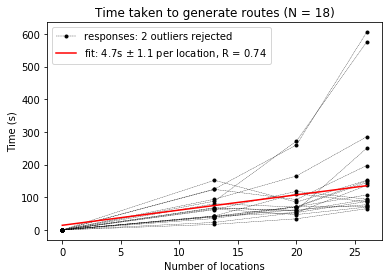

In [37]:
# Get time to complete Questions 4-6
planning_time = survey.loc[:,['Time (13)', 'Time (20)', 'Time (26)']].values.astype(float)
planning_time = np.hstack((np.zeros((planning_time.shape[0], 1)), planning_time))
route_size = np.tile([0,13,20,26], (planning_time.shape[0], 1))

# Do regression, exlcuding outliers 
fltr = (planning_time < 400).all(1)
planning_reg = stats.linregress(route_size[fltr,:].flatten(), planning_time[fltr,:].flatten())

# Calculate 95% interval on slope 
tinv = lambda p, df: abs(stats.t.ppf(p/2, df))
ci = tinv(0.05, len(route_size)-2) * planning_reg.stderr

# Plot data and linear fit
for row in range(planning_time.shape[0]):
    label = f'responses: {(~fltr).sum()} outliers rejected' if row == 0 else None
    plt.plot(route_size[row], planning_time[row], 'k--', linewidth=0.33, marker='.', label=label)
route_size_fit = np.linspace(0,26)
planning_time_fit = lut_reg.intercept + (route_size_fit * planning_reg.slope)
plt.plot(route_size_fit, planning_time_fit, 'r-', label=r'fit: %.1fs $\pm$ %.1f per location, R = %.2f' % (planning_reg.slope, ci, planning_reg.rvalue))
plt.legend()
plt.ylabel('Time (s)')
plt.xlabel('Number of locations')
plt.title(f'Time taken to generate routes (N = {fltr.size})')
plt.savefig('planning_fit.png', dpi=250, bbox_inches='tight')
planning_reg

## Human solution quality
NB this analysis was not used in the paper for the following reasons: 
- Q6 of the survey was flawed because the exact constraints under which VM operates (only one under-sized group) were not specified to respondents, hence some of their solutions violate those same constraints (of which they were not aware...)
- Q5 is an example of a TSP for which humans easily outperform VM, but the discrete nature of the constrained TSP means this is likely a one-off. Hence, a better investigation of the problem would present multiple different TSPs for each value of N in order to average out the effect of an individual problem being especially easy/hard. We don't have the time or resources to launch an in-depth study of human performance on the TSP, nor is it the purpose of this work, so it doesn't make sense for us to go there. We are simply interested in the time it takes people to do the TSP, which the analysis above gives us. 

In [ ]:
# Generate vaximap answers for the survey routes
optimal_costs = []
optimal_routes = []

for arr in [points_13, points_20, points_26]:
    routes, cost = helpers.generate_vaximap_solution(arr, 7)
    optimal_costs.append(cost)
    optimal_routes.append(routes)

optimal_costs = np.array(optimal_costs)

In [ ]:
# Plot vaximap optimised routes
fig, axes = plt.subplots(3, 1, constrained_layout=True, figsize=(6,10))
for ax, cost, rts, points in zip(axes, optimal_costs, optimial_routes, [points_13, points_20, points_26]): 
    for idx in range(points.shape[0]):
        ax.text(*points[idx,:], index2letter[idx], fontsize=12, weight='bold')

    for rtidx,rt in enumerate(rts): 
        for idx in range(rt.size - 1):
            ax.plot(points[[rt[idx], rt[idx+1]],0], points[[rt[idx], rt[idx+1]],1], c=cmap[rtidx,:])
        ax.plot(points[[rt[-1], rt[0]],0], points[[rt[-1], rt[0]],1], c=cmap[rtidx,:])

    ax.set_title(f'{points.shape[0]} points, total cost {cost:.2f}')
    ax.set_xticks([])
    ax.set_yticks([])


In [ ]:
# Calculate the penalty, defined by the fraction difference in length from the vaximap solution
penalty = survey.loc[:, ['Total distance 4', 'Total distance 5', 'Total distance 6']].values
penalty = 100 * (penalty - optimal_costs) / optimal_costs[None,:] 
penalty = np.hstack((np.zeros((penalty.shape[0], 1)), penalty))
route_size = np.tile([0,13,20,26], (penalty.shape[0], 1))

# planning_reg = stats.linregress(route_size.flatten(), lookup_time.flatten())
for row in range(penalty.shape[0]):
    plt.plot(route_size[row], penalty[row], 'k--', linewidth=0.33, label='responses' if row == 0 else None)
# route_size_fit = np.linspace(0,26)
# planning_time_fit = lut_reg.intercept + (route_size_fit * planning_reg.slope)
# plt.plot(route_size_fit, planning_time_fit, 'r-', label=f'fit, {planning_reg.slope:.0f}s per location')
plt.legend()
plt.ylabel('Optimality penalty (%)')
plt.xlabel('Number of locations')
plt.title('Increase in length from optimal')

# planning_reg

In [ ]:
# Plot comparisons of human-generated routes and Vaximap solution

fig, axes = plt.subplots(3, 2, constrained_layout=True, figsize=(12,12))
points = points_26

for row in survey.iloc[:3,:].filter(regex=("Route 6")).itertuples(): 
    ax = axes[row.Index,0]

    for idx in range(points.shape[0]):
        ax.text(*points[idx,:], index2letter[idx], fontsize=12, weight='bold')

    for rtidx,rt in enumerate([row._1, row._2, row._3, row._4]): 
        rt = [ letter2index[r] for r in rt.split(',') ]
        for idx in range(len(rt) - 1):
            ax.plot(points[[rt[idx], rt[idx+1]],0], points[[rt[idx], rt[idx+1]],1], c=cmap[rtidx,:])
        ax.text(*points[rt[0],:] + 0.05 * np.random.uniform(2), len(rt)-1, fontsize=12, color='blue')

    cost = survey.loc[row.Index, 'Total distance 6']
    age = survey.loc[row.Index, 'Age']
    note = survey.loc[row.Index, 'Note']
    ax.set_title(f'{note}, age {age} cost {cost:.2f}')
    ax.set_xticks([])
    ax.set_yticks([])

    ax = axes[row.Index,1]

    for idx in range(points.shape[0]):
        ax.text(*points[idx,:], index2letter[idx], fontsize=12, weight='bold')

    for rtidx,rt in enumerate(optimial_routes[-1]): 
        for idx in range(rt.size - 1):
            ax.plot(points[[rt[idx], rt[idx+1]],0], points[[rt[idx], rt[idx+1]],1], c=cmap[rtidx,:])
        ax.plot(points[[rt[-1], rt[0]],0], points[[rt[-1], rt[0]],1], c=cmap[rtidx,:])
        ax.text(*points[rt[0],:] + 0.05 * np.random.uniform(2), len(rt), fontsize=12, color='blue')

    ax.set_title(f'Vaximap, cost {optimal_costs[-1]:.2f}')
    ax.set_xticks([])
    ax.set_yticks([])